# FVM for Heat Condution problem in 1D

Author: aleksander.grm@fpp.uni-lj.si
<br>
Date: 24/11/2022

In [1]:
import math as mat
import numpy as np
import matplotlib.pyplot as mpl

import scipy.integrate as spint

# MatPlotLib set fonts
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['DejaVu Serif']

# MatPlotLib set LaTeX use
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{siunitx}'

In [2]:
# Define the initial condition

def initial_condition(N):
        u0 = np.zeros(N)
        mid = int(mat.floor((N+1)/2)) - 1
        u0[mid] = 1
        
        return u0

In [3]:
# Define coefficeit of heat conductivity

def coeff_hc(k0,N, distribution):
    k = np.zeros(N)

    # constant
    if distribution == 'constant':
        for i in range(N):
            k[i] = k0
    elif distribution == 'hat':
        dk = k0/(N+1)*2
        k[0] = dk
        for i in range(1,N):
            if i < (N+1)/2:
                k[i] = k[i-1] + dk
            else:
                k[i] = k[i-1] - dk
    else:
        for i in range(N):
            k[i] = k0

    return k

In [4]:
# Set time derivative matrix

def set_dudt(t,u,k,h,N):
    
    dudt = np.zeros(N, dtype=float) # [i,j]: i-row, j-column
    
    # du0/dt
    dudt[0] = k[0]/h**2 * (u[1] - u[0])
    
    # du1/dt, ... , du(N-2)/dt
    for i in range(1,N-1):
        dudt[i] = (k[i]*u[i+1] - (k[i] + k[i-1])*u[i] + k[i-1]*u[i-1])/h**2
    
    # du(N-1)/dt
    dudt[N-1] = k[N-2]/h**2 * (u[N-2] - u[N-1])
    
    return dudt

In [5]:
# Solve one time step
# Forward FD scheme

def find_next(u,dudt,dt,N):
    
    u_new = np.zeros(N)
    
    for i in range(N):
        u_new[i] = u[i] + dudt[i]*dt
        
    return u_new

In [6]:
# Solve explicit time scheme

def solve_time_naive(k,u0,h,dt,tEnd,N):
    
    t = 0
    u = u0
    
    u_sol = []
    while t < tEnd:
        dudt = set_dudt(t,u,k,h,N)
        u_new = find_next(u,dudt,dt,N)
        u_sol.append(u_new)
        
        u = u_new
        t = t + dt
        
    return np.array(u_sol)

In [7]:
def solve_time_correct(k,u0,h,tEnd,N):
    
    sol = spint.solve_ivp(set_dudt, [0,tEnd], u0, args=(k,h,N), method='LSODA')
    
    return [sol.t, sol.y]

In [36]:
# Main program

N = 100 # number of cells (set even number)
h = 1/(N) # cell space
x = np.linspace(0,1,N+1) # positions of cell sides
ux = (np.linspace(0,1,N+1) + h/2)[:N] # positions of cell centers
u0 = initial_condition(N)

k0 = 10.0
k = coeff_hc(k0,N-1,'constant')
#k = coeff_hc(k0,N-1,'hat')

dt = 0.001
tEnd = 0.1

un = solve_time_naive(k,u0,h,dt,tEnd,N)

[tc, uc] = solve_time_correct(k,u0,h,tEnd,N)
print('size(Tc) =', np.shape(tc)[0])

size(Tc) = 145


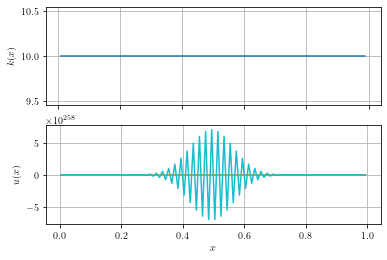

In [32]:
fig, ax = mpl.subplots(2)

ax[0].plot(x[1:N],k)
ax[0].set_xticklabels([])
ax[0].set_ylabel(r'$k(x)$')
ax[0].grid()

Nts = np.shape(un)[0]
for i in range(Nts):
    ax[1].plot(ux,un[i])
    
ax[1].set_xlabel('$x$')
ax[1].set_ylabel('$u(x)$')
ax[1].grid()

fig.savefig('naive_integration.pdf')

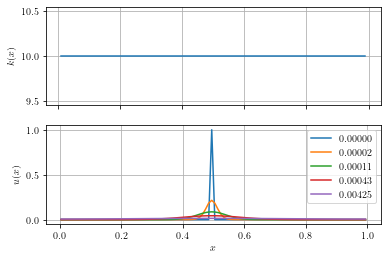

In [37]:
fig, ax = mpl.subplots(2)

ax[0].plot(x[1:N],k)
ax[0].set_xticklabels([])
ax[0].set_ylabel(r'$k(x)$')
ax[0].grid()

Nts = np.shape(uc)[1]
kN = 5
dtk = mat.floor(Nts/kN)
for i in range(kN):
    tStr = '{:.5f}'.format(tc[i*dtk])
    ax[1].plot(ux,uc[:,i*dtk], label=tStr)
ax[1].set_xlabel('$x$')
ax[1].set_ylabel('$u(x)$')
ax[1].grid()
ax[1].legend()

fig.savefig('correct_integration_k=10.pdf')